In [1]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import utils as utils
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm  
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import importlib

importlib.reload(utils)

<module 'utils' from '/Users/AGANGOPA/Desktop/programming/001-upgrad/sessions/006-Lin-reg-assignment/utils.py'>

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_info_columns', 500)

In [4]:
biking = pd.read_csv("day.csv")
biking.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [5]:
biking.shape

(730, 16)

In [6]:
biking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


## Data Cleaning

**Checking duplicate rows**

In [7]:
print(biking.duplicated().sum())

0


**There are no duplicate rows**

**As per the output from the info function above, there are no null values**

**dataset seems to be pretty clean and doesn't need any cleaning**

## Data Preparation - Replacing label encodings with respective words for categorical variables

Some of the variables like 'weathersit' and 'season' have values as 1, 2, 3, 4 which have specific labels associated with them (as can be seen in the data dictionary). These numeric values associated with the labels may indicate that there is some order to them - which is actually not the case (Check the data dictionary and think why). So, it is advisable to convert such feature values into categorical string values before proceeding with model building. 

In [8]:
# Mapping Seasons
season_mapping = {
    1: 'spring',
    2: 'summer',
    3: 'fall',
    4: 'winter'
}

# Replace numeric codes with season names
biking['season'] = biking['season'].replace(season_mapping)

In [9]:
# New mapping for 'weathersit' column with shortened strings
weathersit_mapping_short = {
    1: 'Clear',
    2: 'Mist',
    3: 'Light Precipitation',
    4: 'Heavy Precipitation'
}

# Applying the new mapping
biking['weathersit'] = biking['weathersit'].replace(weathersit_mapping_short)


In [10]:
day_map = {
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday',
}

# Map numeric weekdays to day names in the 'weekday' column
biking['weekday'] = biking['weekday'].map(day_map)

In [11]:
# Mapping from numeric month to month names
month_mapping = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

# Assuming 'df' is your DataFrame and 'mnth' is the column with label-encoded months
biking['mnth'] = biking['mnth'].map(month_mapping)

In [12]:
biking.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,0,January,0,Saturday,0,Mist,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,January,0,Sunday,0,Mist,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,January,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,January,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,January,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Removing following variables due to the following reasons
1. instant - instant value is unique in every row
2. dteday - Month and year are already extracted in other variables
3. casual and registered - target variable cnt is basically the sum of these two variables. Their inclusion in the model will result in data leakage . 

In [13]:
biking.drop(["instant", "dteday", 'casual', 'registered'], inplace=True, axis=1)

In [14]:
biking.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,January,0,Saturday,0,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,January,0,Sunday,0,Mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,January,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,January,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,January,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [15]:
# Set the global font properties
mpl.rcParams['axes.labelweight'] = 'bold'  # For axis labels
mpl.rcParams['axes.titleweight'] = 'bold'  # For titles

## Univariate Analysis

### Primary Univariate analysis for categorical variables

In [16]:
categorical_vars = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
continuous_vars = ['temp', 'atemp', 'hum', 'windspeed']

In [17]:
utils.print_unique_values_with_counts(biking, categorical_vars)

Column 'season' has 4 unique values.
Top 15 unique values and their counts:
fall: 188
summer: 184
spring: 180
winter: 178


Column 'yr' has 2 unique values.
Top 15 unique values and their counts:
0: 365
1: 365


Column 'mnth' has 12 unique values.
Top 15 unique values and their counts:
January: 62
March: 62
May: 62
July: 62
August: 62
October: 62
December: 62
April: 60
June: 60
September: 60
November: 60
February: 56


Column 'holiday' has 2 unique values.
Top 15 unique values and their counts:
0: 709
1: 21


Column 'weekday' has 7 unique values.
Top 15 unique values and their counts:
Saturday: 105
Sunday: 105
Monday: 105
Tuesday: 104
Thursday: 104
Friday: 104
Wednesday: 103


Column 'workingday' has 2 unique values.
Top 15 unique values and their counts:
1: 499
0: 231


Column 'weathersit' has 3 unique values.
Top 15 unique values and their counts:
Clear: 463
Mist: 246
Light Precipitation: 21




- season: The dataset is fairly balanced across the four seasons, with fall having the most entries (188) and winter the fewest (178).
- Year (yr): The dataset is evenly split between two years, each represented by 365 entries.
- Month (mnth): All months are well-represented, with January through August and October through December having 62 entries each, April, June, September, and November with 60, and February with the fewest at 56.
- Holiday: The vast majority of days are non-holidays (709), with only 21 holiday entries.
- Weekday: The distribution across weekdays is fairly even, ranging from 103 entries for Wednesday to 105 for Saturday, Sunday, and Monday.
- Workingday: There are more working days (499) than non-working days (231) in the dataset.
- Weather Situation (weathersit): Most days had clear weather (463 entries), followed by mist (246), with a small number of days having light precipitation (21).

### Primary Univariate analysis for continuous variables

In [18]:
continuous_summary = biking[continuous_vars].describe()
continuous_summary

,temp,atemp,hum,windspeed
count,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620
std,7.506729,8.150308,14.237589,5.195841
min,2.424346,3.953480,0.000000,1.500244
25%,13.811885,16.889713,52.000000,9.041650
50%,20.465826,24.368225,62.625000,12.125325
75%,26.880615,30.445775,72.989575,15.625589
max,35.328347,42.044800,97.250000,34.000021


- Temperature (temp): The average temperature is around 20.32 degree C, with a standard deviation of 7.51 degree C. Temperatures range from a minimum of 2.42 degree C to a maximum of 35.33 degree C.
- Feeling Temperature (atemp): The average 'feels like' temperature is approximately 23.73 degree C, with a standard deviation of 8.15 degree C. The range is from about 3.95 degree C to 42.04 degree C.
- Humidity (hum): The average humidity is 62.77%, with a standard deviation of 14.24%. It ranges from 0% to 97.25%.
- Windspeed: The average windspeed is 12.76 km/h, with a standard deviation of 5.20 km/h. The range is from 1.50 km/h to 34.00 km/h.

### Univariate Analysis with Graphs

**For continuous variables**
- Histograms to understand the distribution of values.
- Boxplots to identify outliers and the spread of data.

**For categorical variables**
- Bar plots to visualize the frequency of each category.

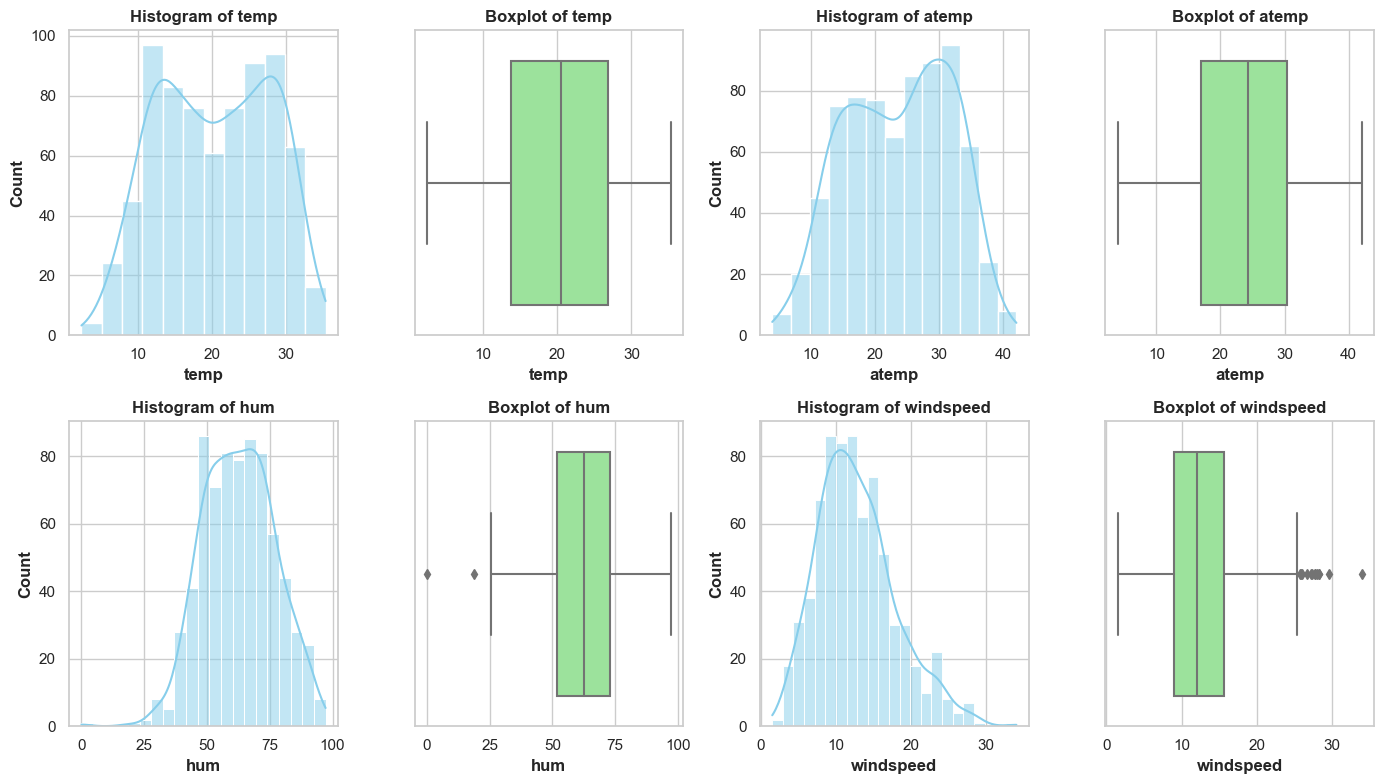

In [19]:
utils.univariate_analysis(biking, continuous_vars)

#### Univariate Analysis Summary from the graphs of the continuous variables

- Temperature (temp) and Feeling Temperature (atemp): Both show a somewhat bimodal distribution, indicating two peaks.There are no significant outliers observed in the boxplots for these variables.
- Humidity (hum): The distribution of humidity is fairly normal but slightly left-skewed, with a few outliers on the lower end, indicating days with very low humidity.
- Windspeed: The distribution of windspeed is right-skewed, with several outliers indicating days with exceptionally high windspeeds.

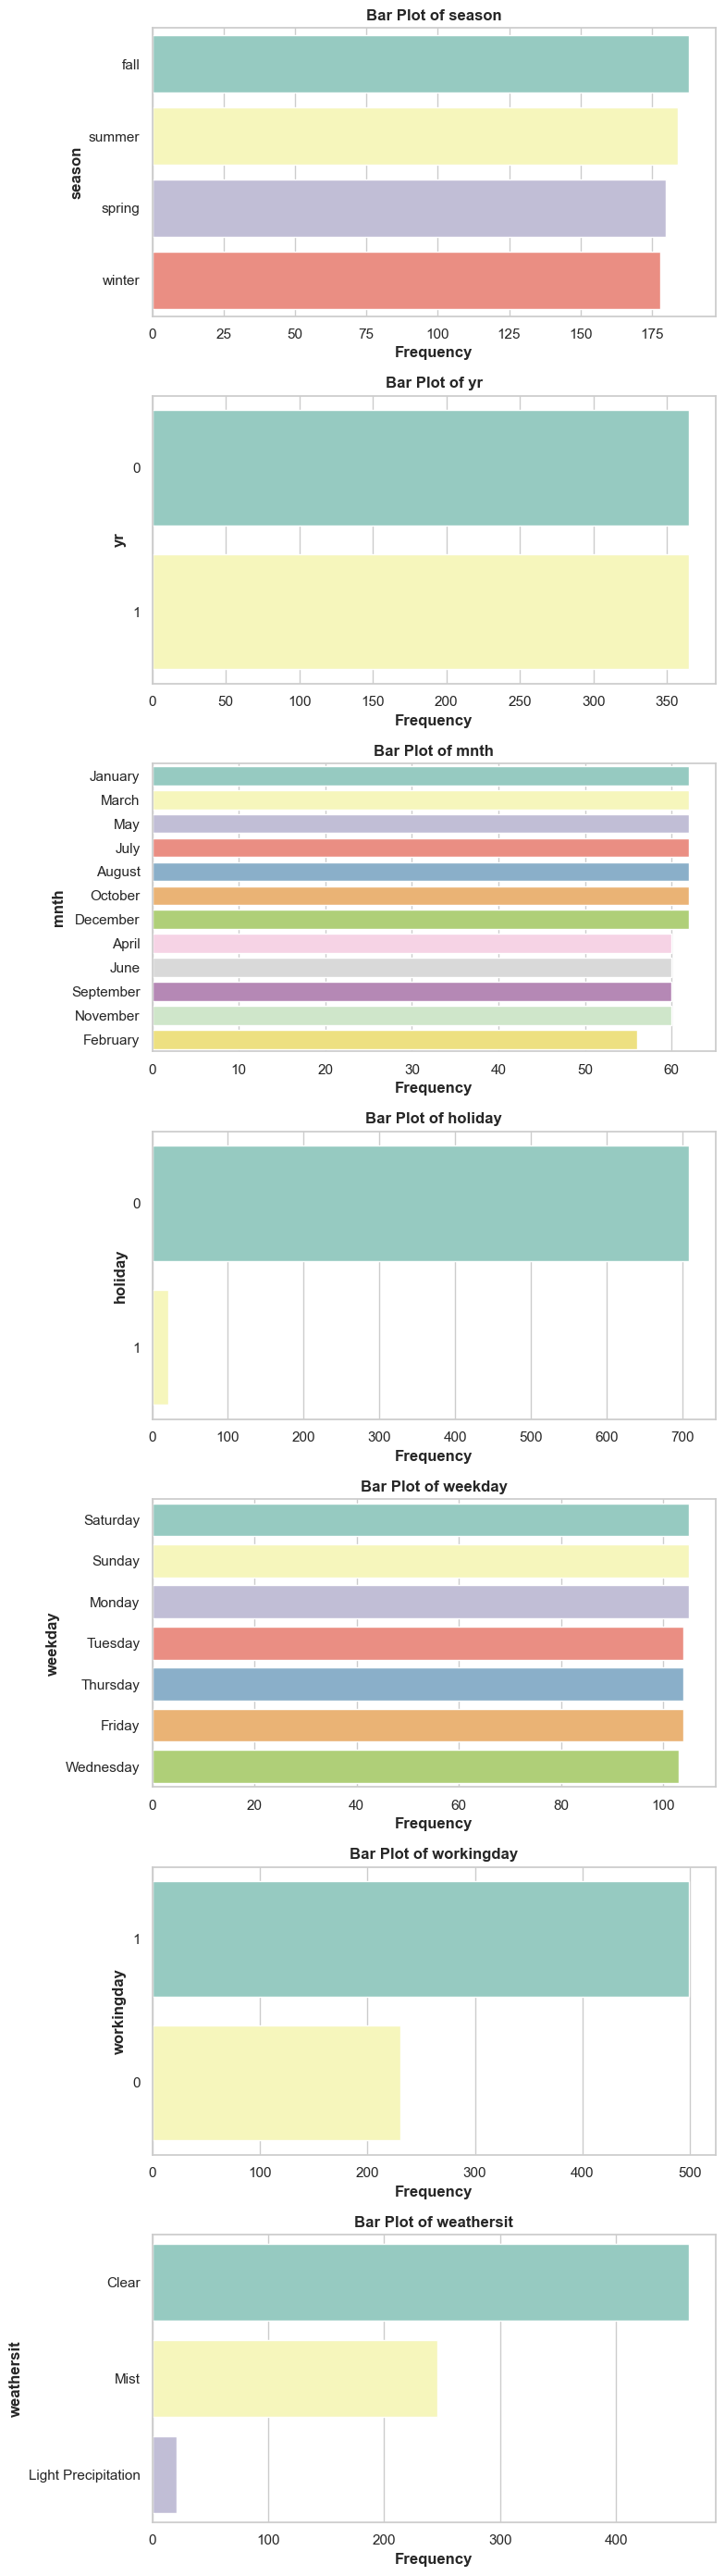

In [20]:
utils.univariate_analysis(biking, categorical_vars)

#### Univariate Analysis Summary from the graphs of the categorical variables

- Season: The bar plot shows a relatively balanced distribution across the four seasons, with fall having a slightly higher frequency.
- Year (yr): The dataset is evenly split between the two years.
- Month (mnth): There's a uniform distribution across most months, with February having slightly fewer days due to its shorter length.
- Holiday: The vast majority of records are non-holiday days, as expected.
- Weekday: The distribution is fairly even across all days of the week.
- Workingday: There are more working days than non-working days in the dataset.
- Weather Situation (weathersit): Clear days are the most common, followed by misty days, and a few instances of light precipitation.

## Bivariate Analysis


- Scatter plots for continuous predictors versus cnt to observe any linear or non-linear relationships.
- Box plots for categorical predictors versus cnt to see the distribution of rentals across different categories.

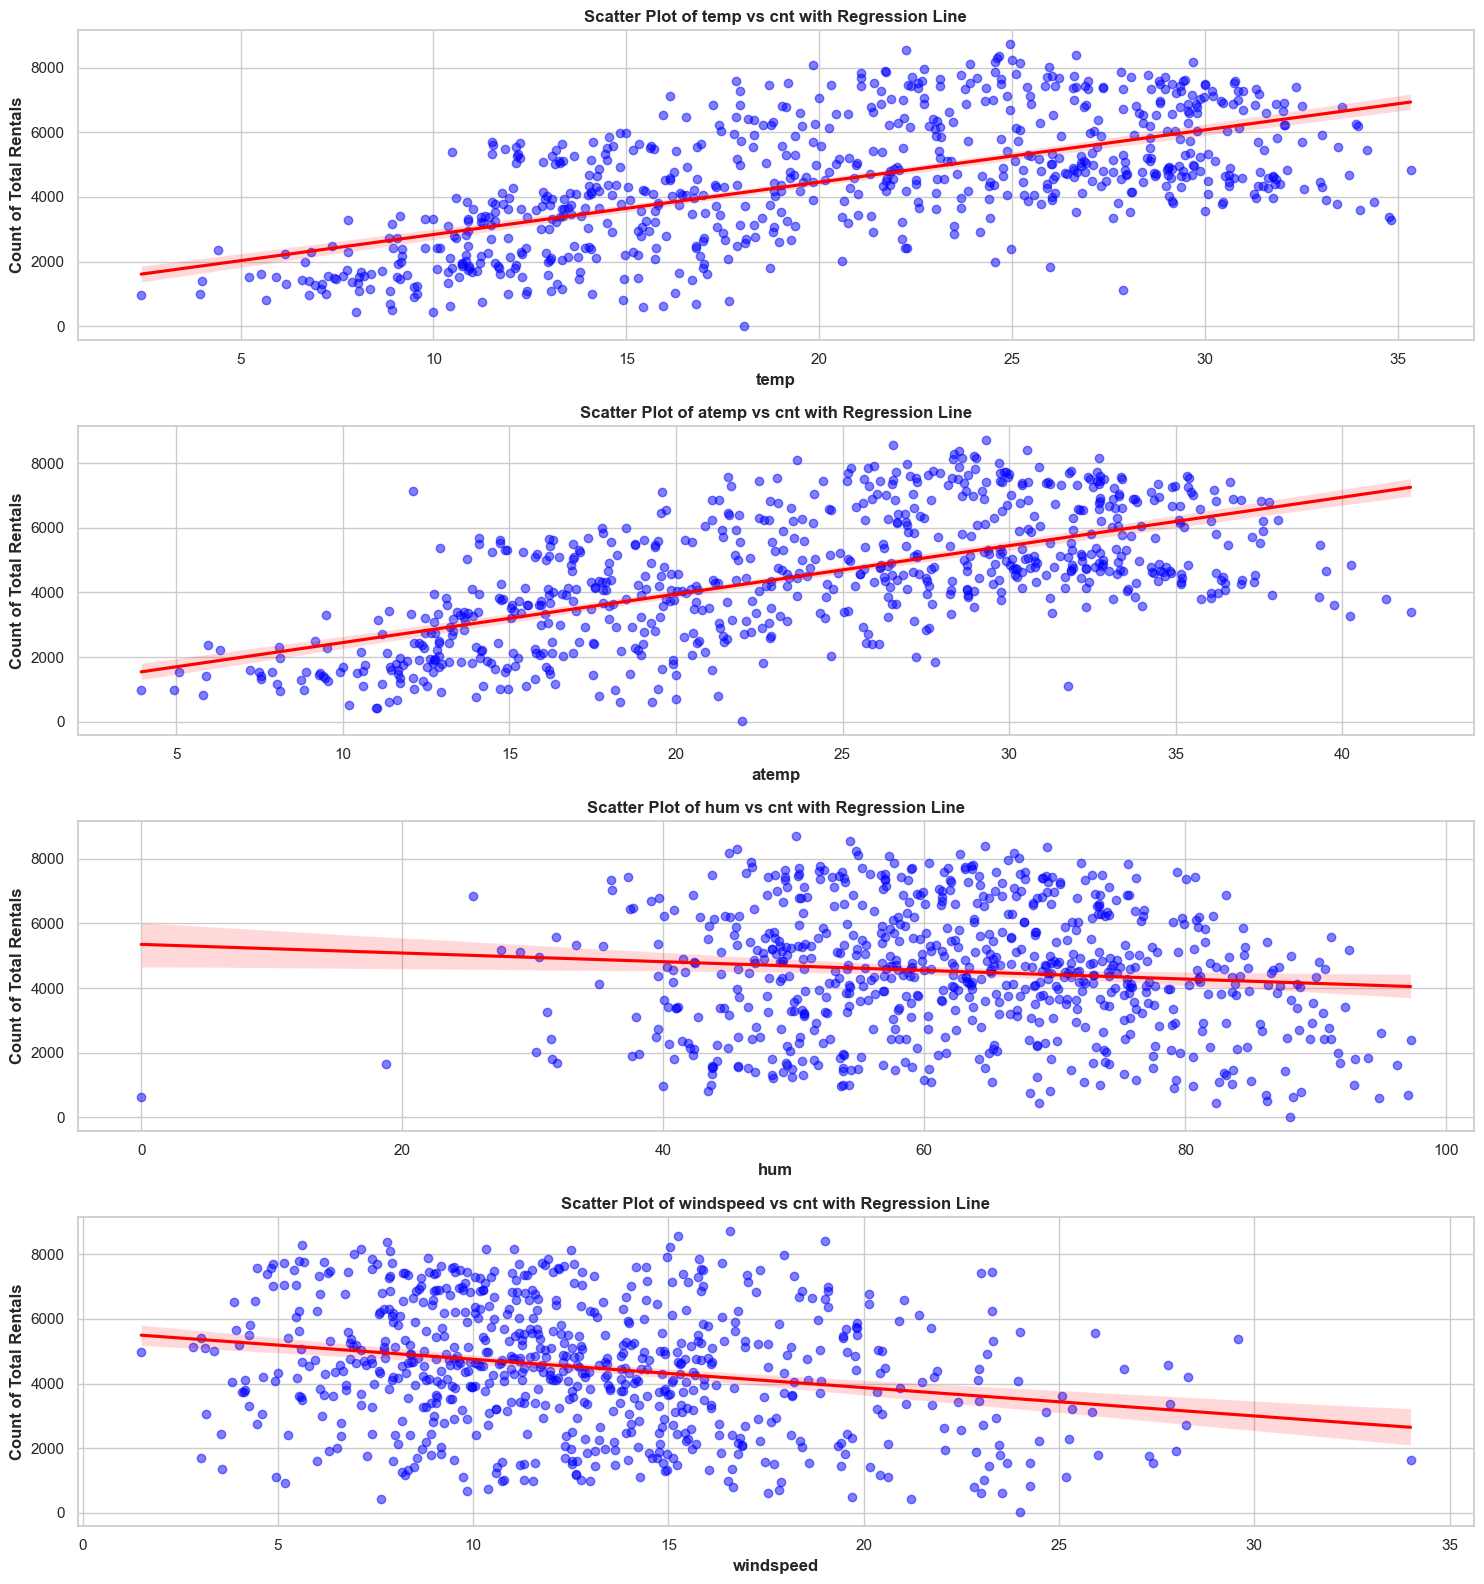

In [21]:
utils.bivariate_analysis(biking, continuous_vars, 'cnt')

### Checking correlations

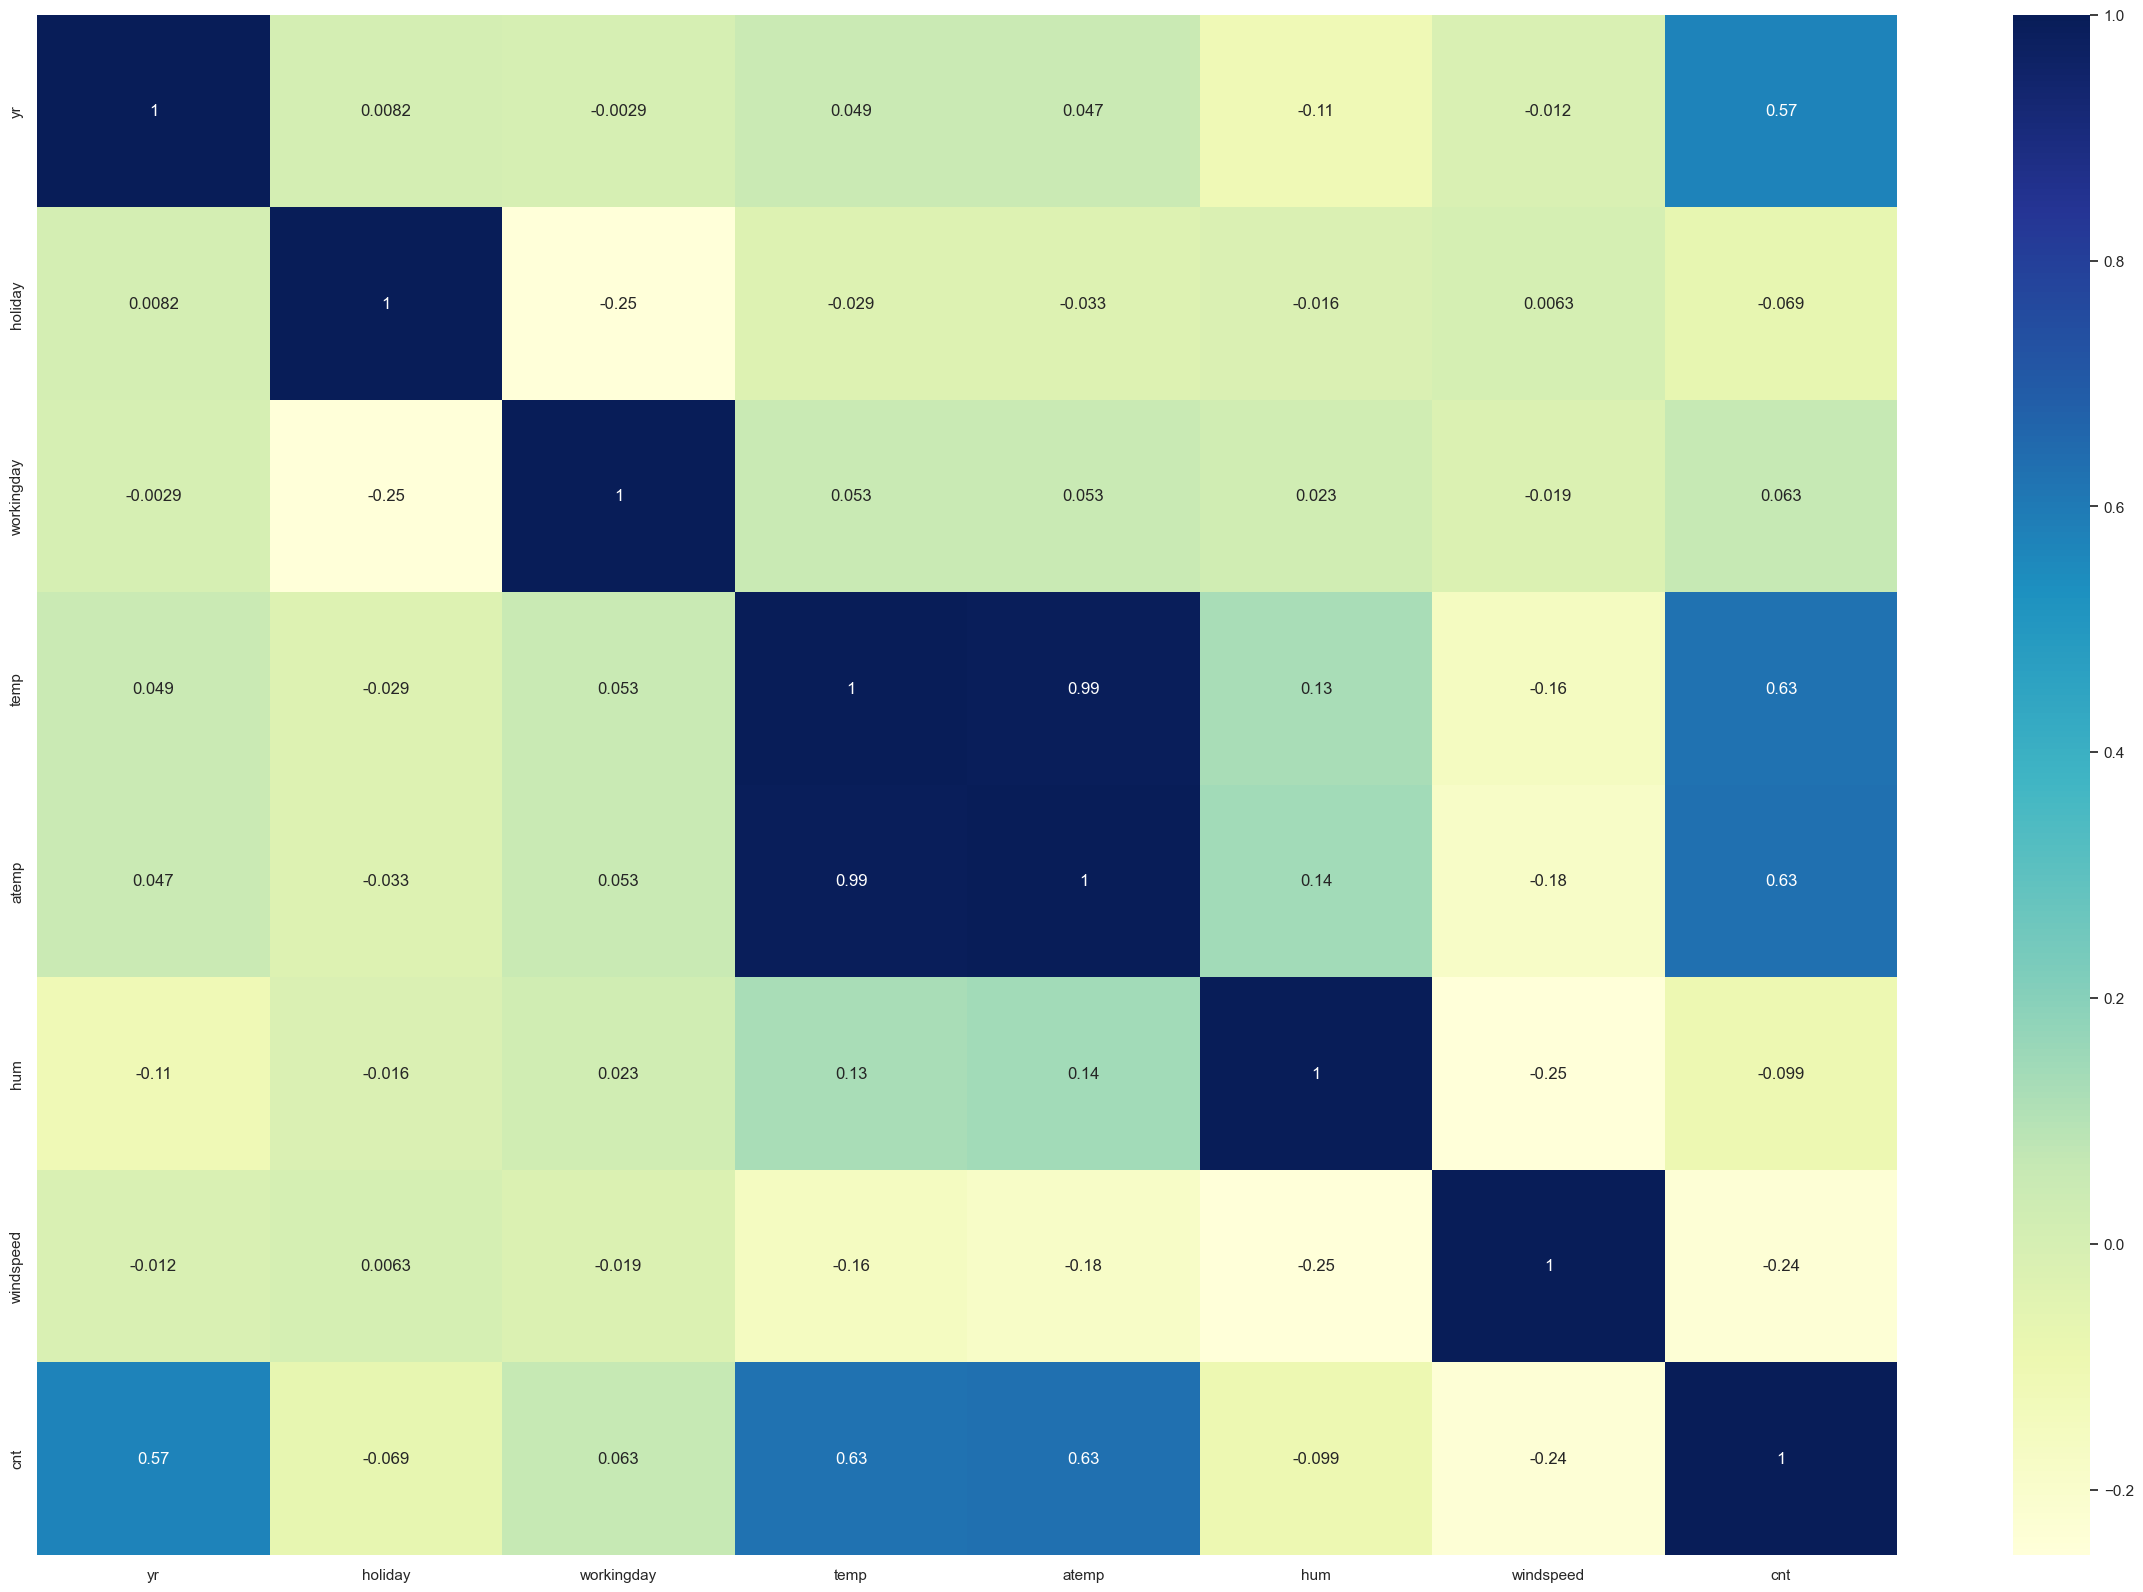

In [22]:
plt.figure(figsize=(30,20))
sns.heatmap(biking.corr(), cmap="YlGnBu", annot = True)
plt.show()

### Bivariate Analysis Summary of Continuous variables with "cnt"
- Temperature (temp) & Feeling Temperature (atemp): Both variables show a positive relationship with cnt, indicating that higher temperatures are associated with an increased count of total rentals. This relationship appears to be somewhat linear, especially in the mid-range of temperatures.
- Humidity (hum): The relationship between humidity and cnt does not show a clear linear trend, suggesting that humidity may not be a strong predictor of bike rentals on its own.
- Windspeed: The scatter plot does not indicate a strong relationship between windspeed and cnt. There seems to be a wide spread of rental counts across different windspeeds, with no clear trend.

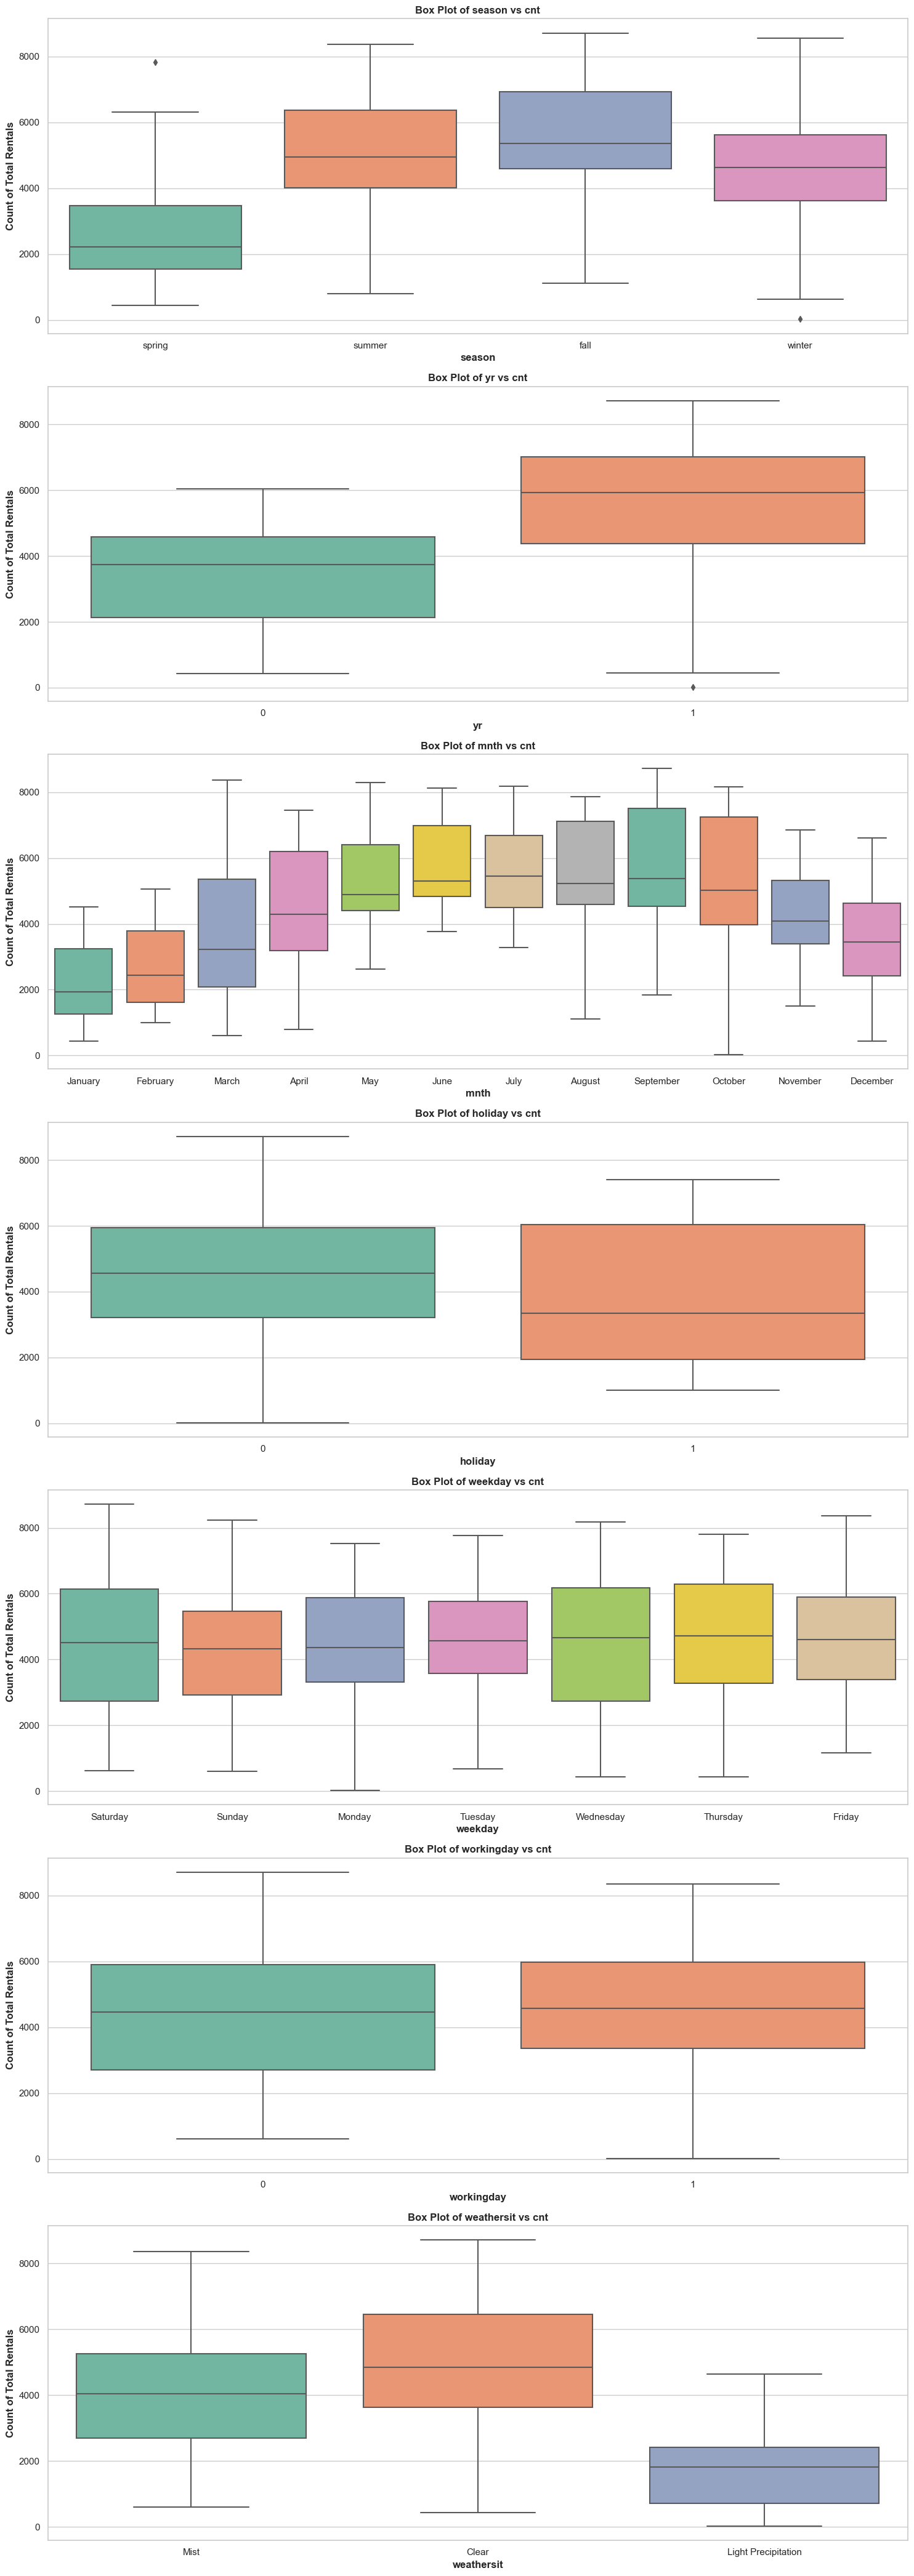

In [23]:
utils.bivariate_analysis(biking, categorical_vars, 'cnt')

### Bivariate Analysis Summary of categorical variables with "cnt"
- Season: The box plots indicate that the count of total rentals varies significantly across different seasons, with higher median rentals in certain seasons (likely spring and summer).
- Year (yr): There's a noticeable difference in the number of rentals between the two years, with one year showing higher median rentals than the other.
- Month (mnth): Similar to seasons, the number of rentals varies across months, reflecting seasonal trends.
- Holiday: The box plots show that non-holiday days tend to have higher counts of rentals compared to holiday days, which is intuitive as more people might use bikes for commuting on regular days.
- Weekday: The distribution of rentals across weekdays does not show significant variation, suggesting that the day of the week may not strongly influence rental counts.
- Workingday: Working days seem to have a slightly higher median rental count compared to non-working days, which aligns with the expectation that bikes are used more for commuting on working days.
- Weather Situation (weathersit): The box plots indicate that the count of rentals varies with different weather conditions, with clear days having higher rental counts compared to days with adverse weather conditions.

## Predictor Analysis 

- Temperature (temp and atemp): Both temperature and 'feels like' temperature have shown a positive relationship with bike rentals. Higher temperatures are associated with increased bike rentals, making these variables significant predictors.

- Season: The season appears to significantly affect bike rentals, with certain seasons (likely spring and summer) showing higher rental counts. This suggests that seasonality is an important factor in predicting bike rentals.

- Weather Situation (weathersit): Weather conditions have a clear impact on bike rentals, with clear days experiencing higher rental counts compared to days with mist or light precipitation. 

- Year (yr): The year variable indicated a difference in rental counts between the two years in the dataset, suggesting an overall increase or decrease in bike rentals over time, which could be due to various factors like growth in bike-sharing popularity or infrastructure changes.

Variables like holiday, workingday, and weekday did not show as strong a relationship with bike rentals in the bivariate analysis, suggesting they might be less significant compared to the aforementioned variables.


**Taking backup**

In [24]:
df_backup = biking.copy()

## Data Preparation - one hot encoding

In [25]:
biking = pd.get_dummies(biking, drop_first=True, dtype=float)

## Train-Test split for cross-validation

In [26]:
df_train, df_test = train_test_split(biking, train_size = 0.7, test_size = 0.3, random_state = 100)

## Data Scaling

In [27]:
scaler = MinMaxScaler()

In [28]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['temp', 'atemp', 'hum', 'windspeed']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,mnth_August,mnth_December,mnth_February,mnth_January,mnth_July,mnth_June,mnth_March,mnth_May,mnth_November,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light Precipitation,weathersit_Mist
653,1,0,1,0.509887,0.501133,0.575354,0.300794,7534,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
576,1,0,1,0.815169,0.766351,0.725633,0.264686,7216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,4066,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,1796,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,4220,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Model Building

In [29]:
y_train = df_train.pop('cnt')
X_train = df_train

In [30]:
# Running RFE with the output number of the variable equal to 15
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(estimator=lm, n_features_to_select=15)               # running RFE
rfe = rfe.fit(X_train, y_train)

In [31]:
utils.print_rfe_stats(X_train, rfe)

('yr', True, 1)
('holiday', True, 1)
('workingday', True, 1)
('temp', True, 1)
('hum', True, 1)
('windspeed', True, 1)
('season_spring', True, 1)
('season_winter', True, 1)
('mnth_January', True, 1)
('mnth_July', True, 1)
('mnth_September', True, 1)
('weekday_Saturday', True, 1)
('weekday_Sunday', True, 1)
('weathersit_Light Precipitation', True, 1)
('weathersit_Mist', True, 1)
('mnth_November', False, 2)
('mnth_December', False, 3)
('season_summer', False, 4)
('mnth_February', False, 5)
('atemp', False, 6)
('mnth_May', False, 7)
('mnth_August', False, 8)
('weekday_Monday', False, 9)
('weekday_Tuesday', False, 10)
('mnth_June', False, 11)
('mnth_March', False, 12)
('weekday_Wednesday', False, 13)
('mnth_October', False, 14)
('weekday_Thursday', False, 15)


In [32]:
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_spring', 'season_winter', 'mnth_January', 'mnth_July', 'mnth_September', 'weekday_Saturday', 'weekday_Sunday', 'weathersit_Light Precipitation', 'weathersit_Mist'], dtype='object')

In [33]:
X_train.columns[~rfe.support_]

Index(['atemp', 'season_summer', 'mnth_August', 'mnth_December', 'mnth_February', 'mnth_June', 'mnth_March', 'mnth_May', 'mnth_November', 'mnth_October', 'weekday_Monday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday'], dtype='object')

In [34]:
# Creating X_train_new dataframe with RFE selected variables
X_train_new = X_train[col]

### Creating new model, Checking Linear model Summary and VIF
**All done by utils.model_analysis, it returns the model in X_train_lm**

In [35]:
# model 1
X_train_new , X_train_lm = utils.model_analysis(X_train_new, y=y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     193.0
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          4.03e-190
Time:                        13:53:28   Log-Likelihood:                -4111.6
No. Observations:                 510   AIC:                             8253.
Df Residuals:                     495   BIC:                             8317.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,Features,VIF
2,workingday,41.60
11,weekday_Saturday,10.14
12,weekday_Sunday,9.82
3,temp,3.19
6,season_spring,2.72
1,holiday,2.58
4,hum,1.90
7,season_winter,1.81
14,weathersit_Mist,1.57
8,mnth_January,1.55


**84.5% variance is explained by the first model, which is quite decent**

**Adjusted R^2 is also decent , showing 84.1%**


### Repeatedly building models and validating the P values/VIF

**In each analysis after building the model and validating the summary/VIF, we will pproceed in the following sequence**
- First we will drop the variables that have both high P value and high VIF 
- Then we will drop variables with high P value , low VIF
- Then we will drop variables with high VIF, low P value

**We will remove the variables with P value greater than 0.05 , and/or VIF greater than 5** 

In [36]:
# model 2
# there is no variable with high P value and high VIF
# holiday has the highest P value. Removing and creating new model
X_train_new , X_train_lm = utils.model_analysis(X_train_new, y=y_train, drop="holiday")

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     193.0
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          4.03e-190
Time:                        13:53:28   Log-Likelihood:                -4111.6
No. Observations:                 510   AIC:                             8253.
Df Residuals:                     495   BIC:                             8317.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,Features,VIF
3,hum,29.73
2,temp,18.10
1,workingday,17.04
10,weekday_Saturday,4.60
4,windspeed,4.55
11,weekday_Sunday,4.47
5,season_spring,3.11
13,weathersit_Mist,2.28
6,season_winter,2.18
0,yr,2.09


In [37]:
# Model 3
# In the last model, there is no variable with both high P value and high VIF. 
# There is no variable with high P value
# So, we will check the variable with highest VIF, which turns out to be  hum
# Removing hum and creating new model
X_train_new , X_train_lm = utils.model_analysis(X_train_new, y=y_train, drop="hum")

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     201.3
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          3.12e-188
Time:                        13:53:28   Log-Likelihood:                -4118.9
No. Observations:                 510   AIC:                             8266.
Df Residuals:                     496   BIC:                             8325.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,Features,VIF
1,workingday,13.48
2,temp,12.76
3,windspeed,4.51
9,weekday_Saturday,3.85
10,weekday_Sunday,3.60
4,season_spring,2.85
0,yr,2.07
5,season_winter,1.79
6,mnth_January,1.65
12,weathersit_Mist,1.58


In [38]:
# model 4
# In the last model, there is no variable with both high P value and high VIF. 
# There is no variable with high P value
# So, we will check the variable with highest VIF, which turns out to be  workingday
# Removing workingday and creating new model
X_train_new , X_train_lm = utils.model_analysis(X_train_new, y=y_train, drop="workingday")

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     210.5
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          4.99e-186
Time:                        13:53:29   Log-Likelihood:                -4126.9
No. Observations:                 510   AIC:                             8280.
Df Residuals:                     497   BIC:                             8335.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,Features,VIF
1,temp,4.75
2,windspeed,4.04
3,season_spring,2.26
0,yr,2.06
5,mnth_January,1.60
11,weathersit_Mist,1.53
4,season_winter,1.41
6,mnth_July,1.36
8,weekday_Saturday,1.22
7,mnth_September,1.20


In [39]:
# model 4
# In the last model, there is no variable with both high P value and high VIF. 
# There is a variable weekday_Saturday with high P value
# Removing weekday_Saturday and creating new model
X_train_new , X_train_lm = utils.model_analysis(X_train_new, y=y_train, drop="weekday_Saturday")

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     229.1
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          8.08e-187
Time:                        13:53:29   Log-Likelihood:                -4127.9
No. Observations:                 510   AIC:                             8280.
Df Residuals:                     498   BIC:                             8331.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,Features,VIF
1,temp,4.69
2,windspeed,4.01
3,season_spring,2.25
0,yr,2.06
5,mnth_January,1.60
10,weathersit_Mist,1.53
4,season_winter,1.40
6,mnth_July,1.36
7,mnth_September,1.20
8,weekday_Sunday,1.17


- Finally we don't have any variable with high VIF or high P value.
- We got a decent R^2 of 0.835, implying our model is able to describe 84.3% variance in the target variable based on the independent variables, indicating a strong predictive capability.
- Adjusted R^2 is 0.831, slightly lower than R^2 is also decent. As we know, adjusted R^2 is a more reliable measure when comparing models with a different number of independent variables.
- In this context, the close values of R^2 and adjusted R^2 suggest that the model is effectively capturing the variance in the data without being overly complex or including unnecessary variables. 
- The high values of both metrics indicate a strong model performance, with the slight difference between them confirming that the number of predictors in the model is appropriate for the amount of data.
- F-statistic is also decent. Prob (F-statistic) is extremely small indicating highly statistically significant.

### Prediction on training data

In [40]:
X_train_lm_final_1 = sm.add_constant(X_train_new)
lm_final_1 = sm.OLS(y_train, X_train_lm_final_1).fit()
y_train_cnt = lm_final_1.predict(X_train_lm_final_1)

### Residual analysis 
To validate assumptions of the model, and hence the reliability for inference

Text(0.5, 0, 'Errors')

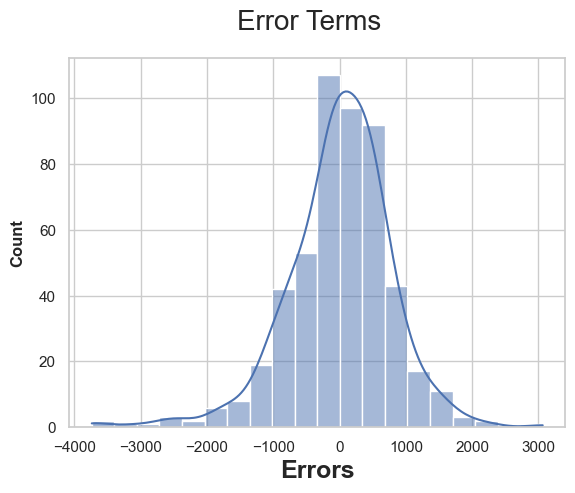

In [41]:
res = y_train - y_train_cnt
fig = plt.figure()
sns.histplot(res, bins=20, kde=True)  # kde=True adds the density curve
fig.suptitle('Error Terms', fontsize=20)  # Plot heading
plt.xlabel('Errors', fontsize=18)  # X-label

**Residuals are almost normally distributed with a mean 0 as per the above graph. All good!**

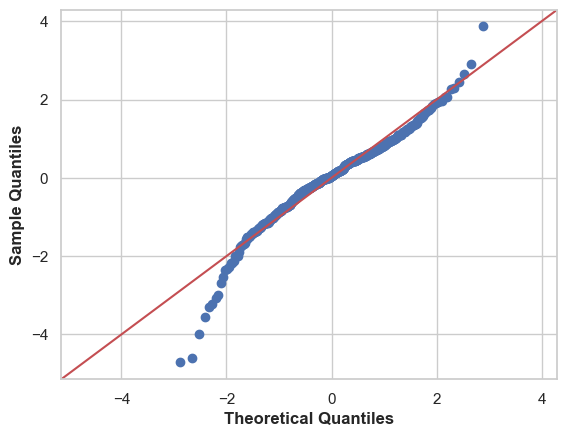

In [42]:
sm.qqplot(res, fit=True, line='45')
plt.show()

**Q-Q plot also looks good**

**Looking for patterns in the residuals  by plotting predicted values against the residuals**

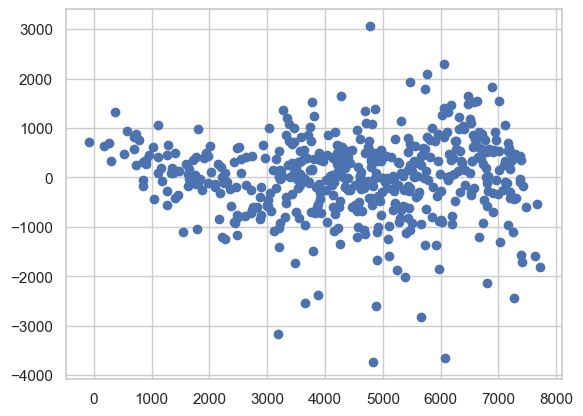

In [43]:
plt.scatter(y_train_cnt, res)
plt.show()

**We can see a random scatter of residuals around the horizontal axis, with no clear pattern, indicating that the model's assumptions are being met.**

### Validating R^2 on train data

In [44]:
r2 = r2_score(y_true=y_train, y_pred=y_train_cnt)
r2

0.8349707097505721

**We've got a decent R^2 - 83.49%**

### Validating mean squared error on train data

In [45]:
mean_squared_error(y_true=y_train, y_pred=y_train_cnt)

627680.8754753466

### Working on predictions on test data

In [46]:
# Scaling test data
num_vars = ['temp', 'atemp', 'hum', 'windspeed']
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [47]:
y_test = df_test.pop('cnt')
X_test = df_test

In [48]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [49]:
# Making predictions
y_pred = lm_final_1.predict(X_test_new)

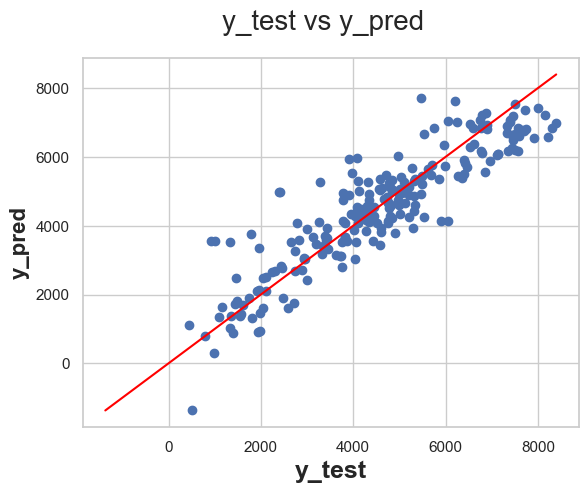

In [50]:
# Plotting y_test vs y_pred
fig = plt.figure()
plt.scatter(y_test, y_pred)

# Adding a line of perfect prediction
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red')  # Diagonal line

# Adding titles and labels
fig.suptitle('y_test vs y_pred', fontsize=20)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)

# Show plot
plt.show()

In [51]:
r2 = r2_score(y_true=y_test, y_pred=y_pred)
r2

0.8050405644499643

In [52]:
mean_squared_error(y_true=y_test, y_pred=y_pred)

699582.5622984258

### Score Analysis

The model's performance, as indicated by the R^2 scores, demonstrates a solid level of predictive accuracy. With a training R^2 score of 83.5%, the model shows a strong fit to the data used for learning, explaining approximately 83.5% of the variance in the training dataset. On the other hand, the testing R^2 score of 80.5% indicates that the model is also effective in generalizing to new, unseen data, maintaining a high level of predictive capability. The close proximity of these two scores suggests that the model is well-balanced, neither overfitting to the training data nor underfitting and failing to capture the underlying trends. This balance is crucial for the reliability of the model in practical applications, as it ensures that the performance observed during training is likely to be replicated in real-world scenarios.

### Equation of our best-fitted line
Based on the OLS regression results, the equation of our best-fitted line is:

cnt = 2385.14 + (2044.46 * yr) + (3756.44 * temp) − (1304.85 * windspeed) − (898.52 * season_spring) + (364.72 * season_winter) − (386.75 * mnth_January) − (573.25 * mnth_July) + (465.57 * mnth_September) − (389.82 * weekday_Sunday) − (2504.89 * weathersit_Light Precipitation) − (696.54 * weathersit_Mist)


## Another Model with binning

**Although we got decent R^2, Trying another model by Binning few variables to see if we can get a better R^2**

In [53]:
biking = df_backup.copy()

In [54]:
biking.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,January,0,Saturday,0,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,January,0,Sunday,0,Mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,January,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,January,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,January,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


### Binning

In [55]:
# Binning 'temp'
biking['temp_bins'] = pd.qcut(biking['temp'], q=3, labels=['Low', 'Medium', 'High'])

# Binning 'atemp'
biking['atemp_bins'] = pd.qcut(biking['atemp'], q=3, labels=['Low', 'Medium', 'High'])

# Binning 'humidity'
biking['hum_bins'] = pd.qcut(biking['hum'], q=3, labels=['Low', 'Medium', 'High'])

# Binning 'windspeed'
biking['windspeed_bins'] = pd.qcut(biking['windspeed'], q=3, labels=['Low', 'Medium', 'High'])


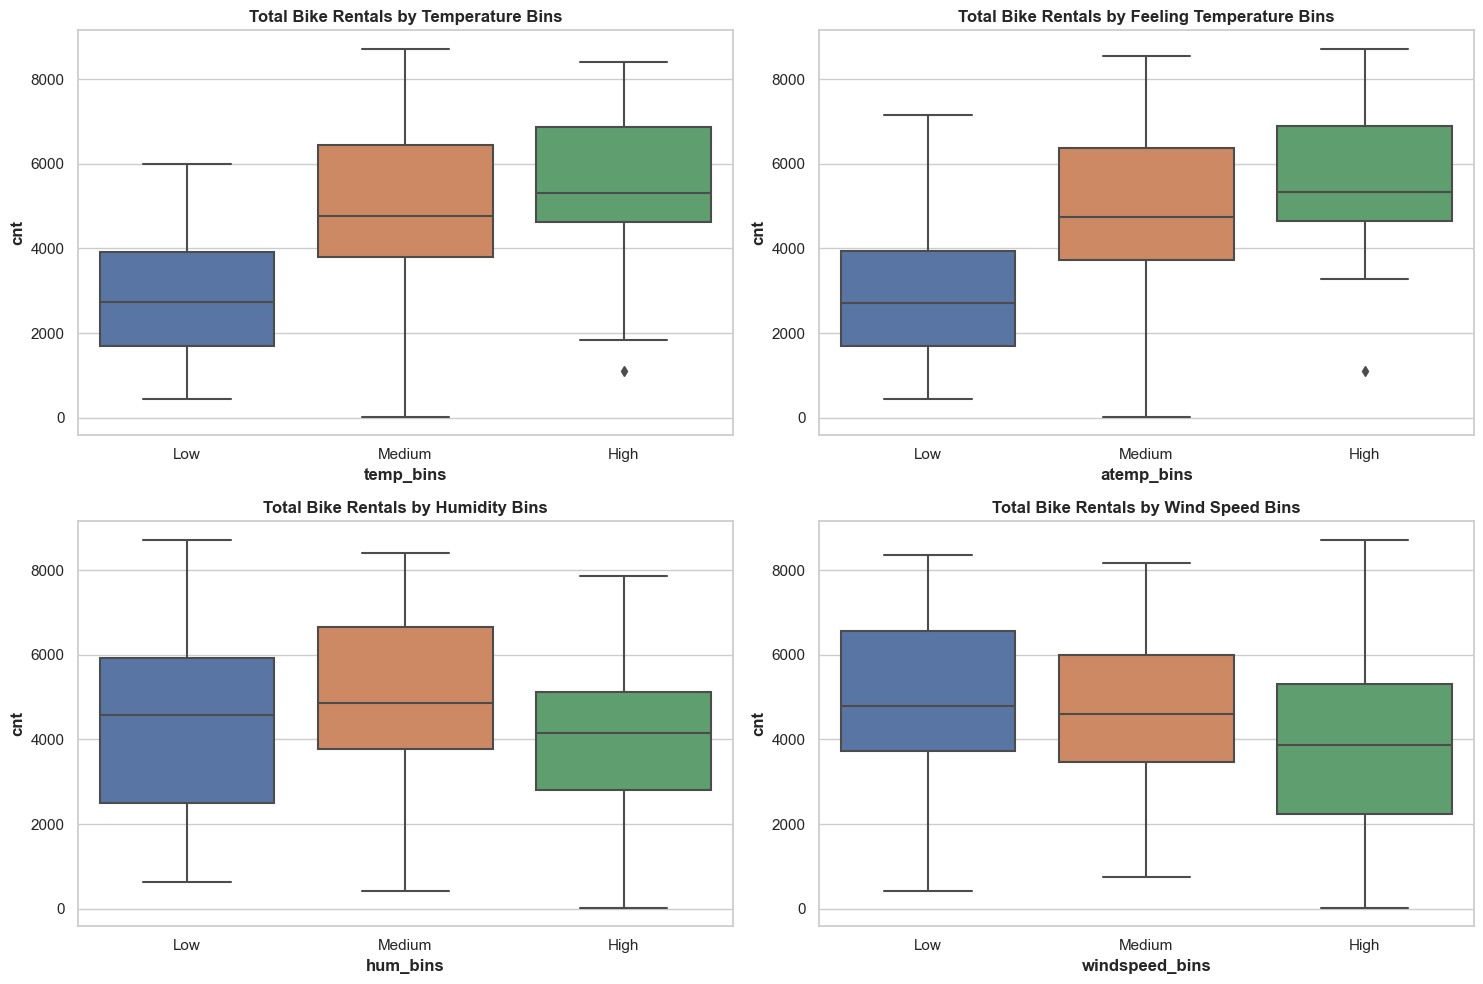

In [56]:
# Bivariate analysis with 'cnt' for each of these bins
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(x='temp_bins', y='cnt', data=biking, ax=axs[0, 0])
axs[0, 0].set_title('Total Bike Rentals by Temperature Bins')

sns.boxplot(x='atemp_bins', y='cnt', data=biking, ax=axs[0, 1])
axs[0, 1].set_title('Total Bike Rentals by Feeling Temperature Bins')

sns.boxplot(x='hum_bins', y='cnt', data=biking, ax=axs[1, 0])
axs[1, 0].set_title('Total Bike Rentals by Humidity Bins')

sns.boxplot(x='windspeed_bins', y='cnt', data=biking, ax=axs[1, 1])
axs[1, 1].set_title('Total Bike Rentals by Wind Speed Bins')

plt.tight_layout()
plt.show()

**Above Violine plots reveal moderate predictive power of the bins.**

**Proceding with model building and evaluation**

### One hot encoding

In [57]:
biking = pd.get_dummies(biking, drop_first=True, dtype=float)

In [58]:
biking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   yr                              730 non-null    int64  
 1   holiday                         730 non-null    int64  
 2   workingday                      730 non-null    int64  
 3   temp                            730 non-null    float64
 4   atemp                           730 non-null    float64
 5   hum                             730 non-null    float64
 6   windspeed                       730 non-null    float64
 7   cnt                             730 non-null    int64  
 8   season_spring                   730 non-null    float64
 9   season_summer                   730 non-null    float64
 10  season_winter                   730 non-null    float64
 11  mnth_August                     730 non-null    float64
 12  mnth_December                   730 

### Train-Test split

In [59]:
# We specify this so that the train and test data set always have the same rows, respectively

df_train, df_test = train_test_split(biking, train_size = 0.7, test_size = 0.3, random_state = 100)

### Scaling data

In [60]:
scaler = MinMaxScaler()

In [61]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['temp', 'atemp', 'hum', 'windspeed']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,mnth_August,mnth_December,mnth_February,mnth_January,mnth_July,mnth_June,mnth_March,mnth_May,mnth_November,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light Precipitation,weathersit_Mist,temp_bins_Medium,temp_bins_High,atemp_bins_Medium,atemp_bins_High,hum_bins_Medium,hum_bins_High,windspeed_bins_Medium,windspeed_bins_High
653,1,0,1,0.509887,0.501133,0.575354,0.300794,7534,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
576,1,0,1,0.815169,0.766351,0.725633,0.264686,7216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,4066,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,1796,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,4220,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,mnth_August,mnth_December,mnth_February,mnth_January,mnth_July,mnth_June,mnth_March,mnth_May,mnth_November,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light Precipitation,weathersit_Mist,temp_bins_Medium,temp_bins_High,atemp_bins_Medium,atemp_bins_High,hum_bins_Medium,hum_bins_High,windspeed_bins_Medium,windspeed_bins_High
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.00000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537262,0.512989,0.650369,0.320768,4486.382353,0.243137,0.245098,0.24902,0.096078,0.084314,0.066667,0.088235,0.076471,0.074510,0.098039,0.084314,0.086275,0.086275,0.080392,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824,0.029412,0.343137,0.347059,0.307843,0.343137,0.311765,0.339216,0.339216,0.319608,0.343137
std,0.500429,0.157763,0.468282,0.225844,0.212385,0.145882,0.169797,1952.158739,0.429398,0.430568,0.43287,0.294988,0.278131,0.249689,0.283915,0.266010,0.262857,0.297660,0.278131,0.281045,0.281045,0.272166,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870,0.169124,0.475223,0.476502,0.462054,0.475223,0.463669,0.473908,0.473908,0.466782,0.475223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,3120.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.540519,0.526811,0.653714,0.296763,4530.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,5973.500000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8714.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Model Building and evaluation with binned variables

In [63]:
y_train = df_train.pop('cnt')
X_train = df_train

In [64]:
# Running RFE with the output number of the variable equal to 25.
# Setting output number to a bit high value since we got a lot of binned variables now
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(estimator=lm, n_features_to_select=25)               # running RFE
rfe = rfe.fit(X_train, y_train)

In [65]:
utils.print_rfe_stats(X_train, rfe)

('yr', True, 1)
('holiday', True, 1)
('workingday', True, 1)
('temp', True, 1)
('atemp', True, 1)
('hum', True, 1)
('windspeed', True, 1)
('season_spring', True, 1)
('season_winter', True, 1)
('mnth_December', True, 1)
('mnth_January', True, 1)
('mnth_July', True, 1)
('mnth_May', True, 1)
('mnth_November', True, 1)
('mnth_September', True, 1)
('weekday_Saturday', True, 1)
('weekday_Sunday', True, 1)
('weathersit_Light Precipitation', True, 1)
('weathersit_Mist', True, 1)
('temp_bins_Medium', True, 1)
('temp_bins_High', True, 1)
('atemp_bins_Medium', True, 1)
('atemp_bins_High', True, 1)
('hum_bins_High', True, 1)
('windspeed_bins_High', True, 1)
('windspeed_bins_Medium', False, 2)
('mnth_August', False, 3)
('mnth_October', False, 4)
('mnth_February', False, 5)
('mnth_June', False, 6)
('weekday_Tuesday', False, 7)
('weekday_Monday', False, 8)
('mnth_March', False, 9)
('hum_bins_Medium', False, 10)
('weekday_Thursday', False, 11)
('weekday_Wednesday', False, 12)
('season_summer', False, 

In [66]:
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'season_spring', 'season_winter', 'mnth_December', 'mnth_January', 'mnth_July', 'mnth_May', 'mnth_November', 'mnth_September', 'weekday_Saturday', 'weekday_Sunday', 'weathersit_Light Precipitation', 'weathersit_Mist', 'temp_bins_Medium', 'temp_bins_High', 'atemp_bins_Medium', 'atemp_bins_High', 'hum_bins_High', 'windspeed_bins_High'], dtype='object')

In [67]:
X_train.columns[~rfe.support_]

Index(['season_summer', 'mnth_August', 'mnth_February', 'mnth_June', 'mnth_March', 'mnth_October', 'weekday_Monday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'hum_bins_Medium', 'windspeed_bins_Medium'], dtype='object')

In [68]:
# Creating X_train_new dataframe with RFE selected variables
X_train_new = X_train[col]

In [69]:
# model 1
X_train_new , X_train_lm = utils.model_analysis(X_train_new, y=y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     129.5
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          1.50e-193
Time:                        13:53:30   Log-Likelihood:                -4076.7
No. Observations:                 510   AIC:                             8203.
Df Residuals:                     485   BIC:                             8309.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,Features,VIF
3,temp,83.25
4,atemp,74.90
2,workingday,61.70
20,temp_bins_High,38.19
22,atemp_bins_High,35.47
19,temp_bins_Medium,19.15
21,atemp_bins_Medium,18.74
15,weekday_Saturday,14.70
16,weekday_Sunday,13.83
5,hum,3.54


In [70]:
# model 2
# In the last model, atemp has both high VIF and high P value. 
# Removing atemp and creating new model
X_train_new , X_train_lm = utils.model_analysis(X_train_new, y=y_train, drop="atemp")

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     134.2
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          7.80e-194
Time:                        13:53:30   Log-Likelihood:                -4078.6
No. Observations:                 510   AIC:                             8205.
Df Residuals:                     486   BIC:                             8307.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,Features,VIF
2,workingday,61.46
19,temp_bins_High,30.66
21,atemp_bins_High,27.05
18,temp_bins_Medium,18.32
20,atemp_bins_Medium,16.97
14,weekday_Saturday,14.66
15,weekday_Sunday,13.77
3,temp,12.12
4,hum,3.53
1,holiday,3.32


In [71]:
# model 3
# In the last model, temp_bins_High has both high VIF and high P value. 
# Removing temp_bins_High and creating new model
X_train_new , X_train_lm = utils.model_analysis(X_train_new, y=y_train, drop="temp_bins_High")

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     140.6
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          6.84e-195
Time:                        13:53:30   Log-Likelihood:                -4078.6
No. Observations:                 510   AIC:                             8203.
Df Residuals:                     487   BIC:                             8301.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,Features,VIF
2,workingday,60.74
14,weekday_Saturday,14.43
15,weekday_Sunday,13.59
19,atemp_bins_Medium,12.34
20,atemp_bins_High,10.53
3,temp,10.36
18,temp_bins_Medium,9.45
4,hum,3.52
1,holiday,3.29
5,windspeed,3.07


In [72]:
# model 4
# In the last model, atemp_bins_Medium has both high VIF and high P value. 
# Removing atemp_bins_Medium and creating new model
X_train_new , X_train_lm = utils.model_analysis(X_train_new, y=y_train, drop="atemp_bins_Medium")

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     147.5
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          5.64e-196
Time:                        13:53:31   Log-Likelihood:                -4078.7
No. Observations:                 510   AIC:                             8201.
Df Residuals:                     488   BIC:                             8294.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,Features,VIF
2,workingday,58.33
14,weekday_Saturday,13.91
15,weekday_Sunday,13.10
3,temp,9.03
19,atemp_bins_High,8.19
4,hum,3.47
1,holiday,3.20
18,temp_bins_Medium,3.12
5,windspeed,3.06
21,windspeed_bins_High,3.00


In [73]:
# model 5
# In the last model, there is no variavle with both high VIF and high P value. 
# So, we will remove the variable with the highest P value, which turns out to be holiday
# Removing holiday and creating new model
X_train_new , X_train_lm = utils.model_analysis(X_train_new, y=y_train, drop="holiday")

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     147.5
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          5.64e-196
Time:                        13:53:31   Log-Likelihood:                -4078.7
No. Observations:                 510   AIC:                             8201.
Df Residuals:                     488   BIC:                             8294.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,Features,VIF
2,temp,52.91
3,hum,51.09
1,workingday,19.68
4,windspeed,12.87
18,atemp_bins_High,11.63
13,weekday_Saturday,5.20
14,weekday_Sunday,4.92
17,temp_bins_Medium,4.73
20,windspeed_bins_High,4.56
19,hum_bins_High,3.76


In [74]:
# model 6
# In the last model, hum has both high VIF and high P value. 
# Removing hum and creating new model
X_train_new , X_train_lm = utils.model_analysis(X_train_new, y=y_train, drop="hum")

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     154.1
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          2.22e-196
Time:                        13:53:31   Log-Likelihood:                -4080.3
No. Observations:                 510   AIC:                             8203.
Df Residuals:                     489   BIC:                             8292.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,Features,VIF
2,temp,38.92
1,workingday,15.55
3,windspeed,12.84
17,atemp_bins_High,10.97
16,temp_bins_Medium,4.60
19,windspeed_bins_High,4.53
12,weekday_Saturday,4.34
13,weekday_Sunday,4.04
5,season_winter,3.32
4,season_spring,3.25


In [75]:
# model 7
# In the last model, there is no variable with both high VIF and high P value
# Hence, we will remove the variable with the highest P value, which turns out to be mnth_November
# Removing mnth_November and creating new model
X_train_new , X_train_lm = utils.model_analysis(X_train_new, y=y_train, drop="mnth_November")

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     161.4
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          6.84e-197
Time:                        13:53:31   Log-Likelihood:                -4081.8
No. Observations:                 510   AIC:                             8204.
Df Residuals:                     490   BIC:                             8288.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,Features,VIF
2,temp,38.87
1,workingday,15.53
3,windspeed,12.69
16,atemp_bins_High,10.84
18,windspeed_bins_High,4.51
15,temp_bins_Medium,4.42
11,weekday_Saturday,4.34
12,weekday_Sunday,4.04
4,season_spring,3.25
17,hum_bins_High,2.43


In [76]:
# model 8
# In the last model, there is no variable with both high VIF and high P value
# Hence, we will remove the variable with the highest P value, which turns out to be mnth_December
# Removing mnth_December and creating new model
X_train_new , X_train_lm = utils.model_analysis(X_train_new, y=y_train, drop="mnth_December")

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     169.4
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          2.63e-197
Time:                        13:53:31   Log-Likelihood:                -4083.5
No. Observations:                 510   AIC:                             8205.
Df Residuals:                     491   BIC:                             8285.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,Features,VIF
2,temp,38.51
1,workingday,15.01
3,windspeed,12.64
15,atemp_bins_High,10.84
17,windspeed_bins_High,4.50
14,temp_bins_Medium,4.40
10,weekday_Saturday,4.19
11,weekday_Sunday,3.95
4,season_spring,3.21
16,hum_bins_High,2.43


In [77]:
# model 9
# In the last model, there is no variable with both high VIF and high P value
# Hence, we will remove the variable with the highest P value, which turns out to be mnth_January
# Removing mnth_January and creating new model
X_train_new , X_train_lm = utils.model_analysis(X_train_new, y=y_train, drop="mnth_January")

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     178.6
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          7.82e-198
Time:                        13:53:31   Log-Likelihood:                -4084.9
No. Observations:                 510   AIC:                             8206.
Df Residuals:                     492   BIC:                             8282.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,Features,VIF
2,temp,37.09
1,workingday,14.58
3,windspeed,12.58
14,atemp_bins_High,10.74
16,windspeed_bins_High,4.42
13,temp_bins_Medium,4.40
9,weekday_Saturday,4.09
10,weekday_Sunday,3.87
4,season_spring,2.79
15,hum_bins_High,2.42


In [78]:
# model 10
# In the last model, there is no variable with both high VIF and high P value
# Hence, we will remove the variable with the highest P value, which turns out to be mnth_May
# Removing mnth_May and creating new model
X_train_new , X_train_lm = utils.model_analysis(X_train_new, y=y_train, drop="mnth_May")

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     188.7
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          2.74e-198
Time:                        13:53:31   Log-Likelihood:                -4086.6
No. Observations:                 510   AIC:                             8207.
Df Residuals:                     493   BIC:                             8279.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,Features,VIF
2,temp,36.79
1,workingday,14.48
3,windspeed,12.56
13,atemp_bins_High,10.62
15,windspeed_bins_High,4.41
12,temp_bins_Medium,4.39
8,weekday_Saturday,4.08
9,weekday_Sunday,3.85
4,season_spring,2.65
14,hum_bins_High,2.34


In [79]:
# model 11
# In the last model, atemp_bins_High has both high VIF and high P value
# Removing atemp_bins_High and creating new model
X_train_new , X_train_lm = utils.model_analysis(X_train_new, y=y_train, drop="atemp_bins_High")

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     200.1
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          1.03e-198
Time:                        13:53:31   Log-Likelihood:                -4088.4
No. Observations:                 510   AIC:                             8209.
Df Residuals:                     494   BIC:                             8276.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,Features,VIF
1,workingday,13.62
2,temp,13.24
3,windspeed,12.56
14,windspeed_bins_High,4.41
8,weekday_Saturday,3.88
9,weekday_Sunday,3.64
4,season_spring,2.51
13,hum_bins_High,2.34
0,yr,2.14
11,weathersit_Mist,2.13


In [80]:
# model 12
# In the last model, we don't see any variable with both high VIF and high P value
# we don't see any variable with high P value either (0.5 being our threshold) ,
# Hence next target is variable with the highest VIF, which turns out to be workingday
# Removing workingday and creating new model
X_train_new , X_train_lm = utils.model_analysis(X_train_new, y=y_train, drop="workingday")

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     208.2
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          5.20e-197
Time:                        13:53:31   Log-Likelihood:                -4095.2
No. Observations:                 510   AIC:                             8220.
Df Residuals:                     495   BIC:                             8284.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,Features,VIF
2,windspeed,11.36
1,temp,6.31
13,windspeed_bins_High,4.28
12,hum_bins_High,2.34
0,yr,2.13
10,weathersit_Mist,2.07
11,temp_bins_Medium,1.77
3,season_spring,1.76
4,season_winter,1.46
5,mnth_July,1.44


In [81]:
# model 13
# In the last model, there is no variable with both high VIF and high P value
# Hence, we will remove the variable with the highest P value, which turns out to be weekday_Saturday
# Removing weekday_Saturday and creating new model
X_train_new , X_train_lm = utils.model_analysis(X_train_new, y=y_train, drop="weekday_Saturday")

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     223.5
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          1.03e-197
Time:                        13:53:31   Log-Likelihood:                -4096.3
No. Observations:                 510   AIC:                             8221.
Df Residuals:                     496   BIC:                             8280.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,Features,VIF
2,windspeed,11.29
1,temp,6.27
12,windspeed_bins_High,4.28
11,hum_bins_High,2.34
0,yr,2.13
9,weathersit_Mist,2.06
10,temp_bins_Medium,1.77
3,season_spring,1.75
4,season_winter,1.45
5,mnth_July,1.44


In [82]:
# model 16
# In the last model, we don't see any variable with both high VIF and high P value
# we don't see any variable with high P value either (0.5 being our threshold) ,
# Hence next target is variable with the highest VIF, which turns out to be windspeed
# Removing windspeed and creating new model
X_train_new , X_train_lm = utils.model_analysis(X_train_new, y=y_train, drop="windspeed")

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     221.8
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          9.37e-191
Time:                        13:53:31   Log-Likelihood:                -4115.7
No. Observations:                 510   AIC:                             8257.
Df Residuals:                     497   BIC:                             8312.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,Features,VIF
1,temp,3.95
10,hum_bins_High,2.31
0,yr,2.13
8,weathersit_Mist,2.02
9,temp_bins_Medium,1.76
11,windspeed_bins_High,1.59
4,mnth_July,1.44
3,season_winter,1.41
2,season_spring,1.36
7,weathersit_Light Precipitation,1.21


- Finally we don't have any high VIF or high P value.
- We got a decent R^2 of 0.843, implying our model is able to describe 84.3% variance in the target variable based on the independent variables, indicating a strong predictive capability.
- Adjusted R^2 is 0.839, slightly lower than R^2 is also decent. As we know, adjusted R^2 is a more reliable measure when comparing models with a different number of independent variables.
- In this context, the close values of R^2 and adjusted R^2 suggest that the model is effectively capturing the variance in the data without being overly complex or including unnecessary variables. 
- The high values of both metrics indicate a strong model performance, with the slight difference between them confirming that the number of predictors in the model is appropriate for the amount of data.

### Prediction on training data

In [83]:
X_train_lm_final_2 = sm.add_constant(X_train_new)
lm_final_2 = sm.OLS(y_train, X_train_lm_final_2).fit()
y_train_cnt = lm_final_2.predict(X_train_lm_final_2)

### Residual Analysis

Text(0.5, 0, 'Errors')

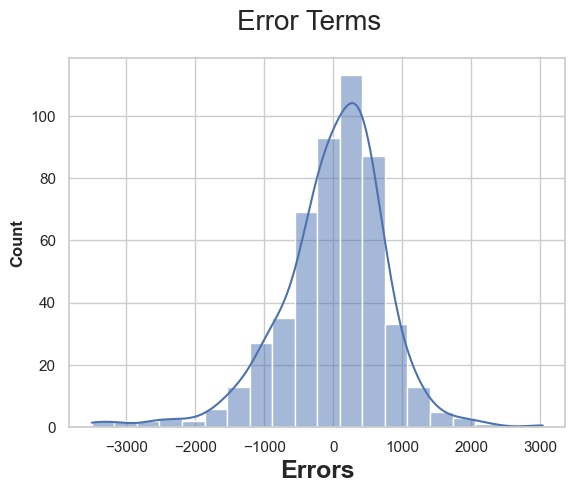

In [84]:
fig = plt.figure()
sns.histplot((y_train - y_train_cnt), bins=20, kde=True)  # kde=True adds the density curve
fig.suptitle('Error Terms', fontsize=20)  # Plot heading
plt.xlabel('Errors', fontsize=18)  # X-label

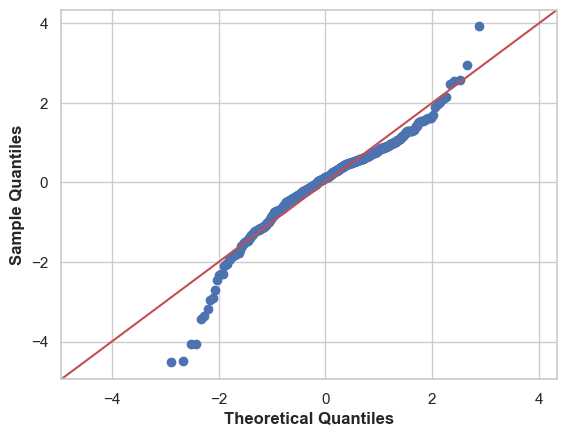

In [85]:
sm.qqplot((y_train - y_train_cnt), fit=True, line='45')
plt.show()

**Residuals are normally distributed as per the above graph**

**Looking for patterns in the residuals  by plotting predicted values against the residuals**

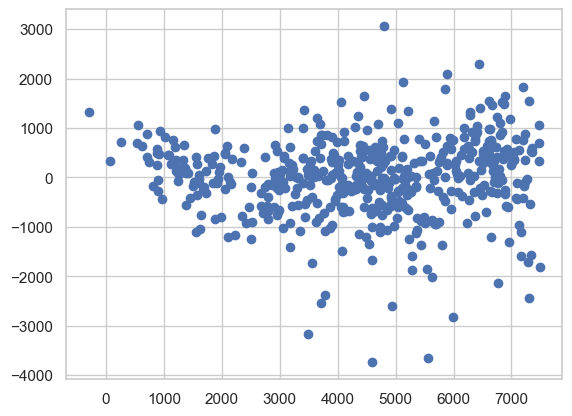

In [86]:
plt.scatter(y_train_cnt, res)
plt.show()

**We can see a random scatter of residuals around the horizontal axis, with no clear pattern, indicating that the model's assumptions are being met.**

### Validating R^2 on train data

In [87]:
r2 = r2_score(y_true=y_train, y_pred=y_train_cnt)
r2

0.842654287845076

We've got R^2 score of 84.26% on training data , which is slightly better than the previous R^2 score of 83.49% on train data, that we got without binning

### Validating mean squared error on train data

In [88]:
mean_squared_error(y_true=y_train, y_pred=y_train_cnt)

598456.7600601248

### Working on predictions on test data

In [89]:
# Scaling test data
num_vars = ['temp', 'atemp', 'hum', 'windspeed']

df_test[num_vars] = scaler.transform(df_test[num_vars])

In [90]:
y_test = df_test.pop('cnt')
X_test = df_test

In [91]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [92]:
# Making predictions
y_pred = lm_final_2.predict(X_test_new)

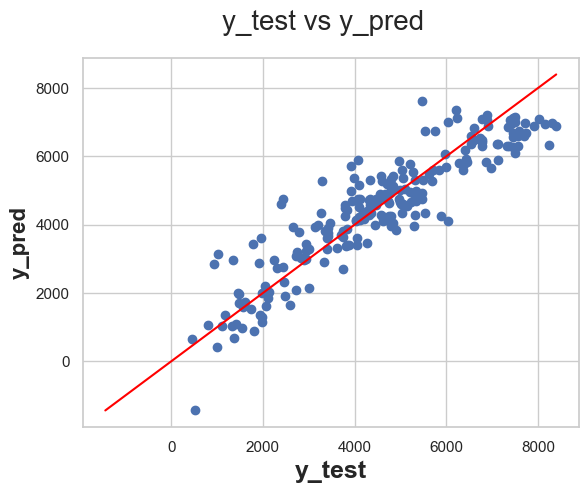

In [93]:
# Plotting y_test vs y_pred
fig = plt.figure()
plt.scatter(y_test, y_pred)

# Adding a line of perfect prediction
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red')  # Diagonal line

# Adding titles and labels
fig.suptitle('y_test vs y_pred', fontsize=20)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)

# Show plot
plt.show()

In [94]:
# R^2 of test data
r2 = r2_score(y_true=y_test, y_pred=y_pred)
r2

0.8267751577450532

In [95]:
# mean squared error of test data
mean_squared_error(y_true=y_test, y_pred=y_pred)

621591.2487464837

### Score Analysis

- The model's performance, as indicated by the R^2 scores, demonstrates a solid level of predictive accuracy.
- With a training R^2 score of 84.3%, the model shows a strong fit to the data used for learning, explaining approximately 84.3% of the variance in the training dataset. 
- On the other hand, the testing R^2 score of 82.7% indicates that the model is also effective in generalizing to new, unseen data, maintaining a high level of predictive capability. 
- The close proximity of these two scores suggests that the model is well-balanced, neither overfitting to the training data nor underfitting and failing to capture the underlying trends. This balance is crucial for the reliability of the model in practical applications, as it ensures that the performance observed during training is likely to be replicated in real-world scenarios.
- F-statistic is also decent. Prob (F-statistic) is extremely small indicating highly statistically significant.

### Equation of our best-fitted line
Based on the OLS regression results, the equation of our best-fitted line is:

cnt = 1758.74 + (1959.55 * yr) + (4047.22 * temp) − (885.74 * season_spring) + (432.54 * season_winter) − (463.05 * mnth_July) + (491.14 * mnth_September) − (334.00 * weekday_Sunday) − (2486.63 * weathersit_Light Precipitation) − (550.44 * weathersit_Mist) + (534.48 * temp_bins_Medium) − (309.54 * hum_bins_High) − (317.70 * windspeed_bins_High)

### Final Conclusion

We created two models lm_final_1 and lm_final_2. The first model was created without binning , and second model was created by binning few variables.

The comparative analysis of the two models indicates that the second model outperforms the first in both training and testing phases. The second model has a higher training R^2 score of 84.3% compared to the first model's 83.5%, suggesting a slightly better fit to the training data. More importantly, the testing R^2 score for the second model is 82.7%, which is higher than the first model's 80.5%, indicating a stronger ability to generalize to unseen data. This aspect is crucial for the practical application of the model, as it suggests the second model is more reliable when making predictions on new datasets.

Additionally, the mean squared error (MSE) metrics further support the superiority of the second model. The second model shows a lower training MSE of 598,456.76 and a lower testing MSE of 621,591.25 compared to the first model's training MSE of 627,680.88 and testing MSE of 699,582.56. Lower MSE values indicate that the second model's predictions are closer to the actual values, enhancing its predictive accuracy.

Considering these factors—the R^2 scores indicating the proportion of variance explained by the models and the MSE indicating the average squared difference between the estimated and actual values—the second model is the preferable choice. Its superior performance in terms of both fit to the training data and generalization to the testing data, coupled with lower error rates, make it the more reliable and accurate model for predicting outcomes in real-world scenarios.